In [115]:
!pip install pystan==2.19.1.1
!pip install fbprophet==0.7.0
!pip install neuralprophet

In [31]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
from torchinfo import summary

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## EDA with preprocessing

In [4]:
DATASET_PATH = os.path.join('./data')

In [5]:
# Prophet 모델에 맞춰, 날짜 시간을 통합하고 Datetime으로 변경한 DataFrame을 Return
def col_timestamp(mode):
    # mode: strin - 'train', 'validate', 'test'
    # csv 불러오기
    df = pd.read_csv(os.path.join(DATASET_PATH, mode+'.csv'))
    
    # ds, Time으로 컬럼명 변경
    new_df = df.rename(columns={'날짜':'ds', '시간':'Time'})
    
    # cols = 내용 합치려는 컬럼명, 컬럼의 내용을 합치고 사이에 구분자로 ':'를 넣기
    cols = ['ds', 'Time']
    new_df['ds'] = new_df[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
    
    # 필요없어진 Time 컬럼 제거
    new_df = new_df.drop(columns = ['Time'])
    
    # Datetime Type으로 변경 - format %Y 연도 네 자리, %m 달 2자리, %d 일 2자리 :(구분자) %H (시간)
    new_df['ds'] = pd.to_datetime(new_df['ds'], format='%Y%m%d:%H')
    return new_df

In [6]:
# scaling(DataFrame, mode), mode는 string ('train', 'val', 'test') 입력
# scaler 설정
scaler = StandardScaler()

def scaling(df, mode):    
    # ds 컬럼을 제외하고 슬라이싱
    values_df = df.iloc[:, 1:]
    # concat 이후 컬럼명 변경을 위해 미리 컬럼명 저장
    cols = values_df.columns
    
    # train data 기준 Fit
    if mode == 'train':
        scaler.fit(values_df)
    
    # Scaling, 컬럼명 변경, ds컬럼과 다시 합치기
    scaled_values = pd.DataFrame(scaler.transform(values_df), columns=cols)    
    scaled_df = pd.concat([df.iloc[:,0], scaled_values], axis=1)
    
    # csv export
    #scaled_df.to_csv(os.path.join(DATASET_PATH, 'scaled_' + mode.csv), index=False)
    
    return scaled_df

def unscaling(df):
    # 시간 컬럼 제외
    values_df = df.iloc[:, 1:]
    cols = values_df.columns
    
    unscaled_values = pd.DataFrame(scaler.inverse_transform(values_df), columns=cols)
    unscaled_df = pd.concat([df.iloc[:,0], unscaled_values], axis=1)
    
    return unscaled_df

In [7]:
train_df = col_timestamp('train')
train_df

,ds,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01 00:00:00,83247,19128,2611,5161,1588,892,32263,1636,7938,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,2020-01-01 01:00:00,89309,19027,3337,5502,1650,1043,35609,1644,9896,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,2020-01-01 02:00:00,66611,14710,2970,4631,1044,921,26821,1104,9343,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,2020-01-01 03:00:00,53290,13753,2270,4242,1021,790,21322,909,10009,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,2020-01-01 04:00:00,52095,17615,2406,3689,1840,922,22711,1354,15497,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,2020-05-17 19:00:00,311727,101285,10085,30637,10060,8749,148935,6801,26101,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,2020-05-17 20:00:00,305354,91426,8607,26021,8095,7198,136503,6147,20759,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,2020-05-17 21:00:00,306008,75113,6325,19933,5711,4494,129412,5134,14496,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,2020-05-17 22:00:00,237447,49498,4209,12145,3891,2718,96698,3526,9363,...,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


In [8]:
scaled_train = scaling(train_df, 'train')

In [9]:
scaled_train

,ds,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01 00:00:00,-1.217013,-1.142035,-0.813618,-0.913505,-1.053905,-1.072626,-1.147111,-0.965372,-0.395574,...,-0.990008,-1.205047,-1.017020,-0.961316,-0.904783,-1.130552,-0.913565,-1.023009,-1.116140,-1.094880
1,2020-01-01 01:00:00,-1.167309,-1.144460,-0.683299,-0.887910,-1.040942,-1.029875,-1.089849,-0.962570,-0.171206,...,-1.028472,-1.145526,-0.896491,-0.722831,-0.878570,-1.135464,-0.895440,-1.077666,-1.130734,-1.072134
2,2020-01-01 02:00:00,-1.353416,-1.248142,-0.749177,-0.953287,-1.167641,-1.064416,-1.240242,-1.151710,-0.234575,...,-1.130181,-1.396910,-1.229307,-1.192362,-0.816589,-1.191269,-1.050574,-1.183853,-1.232699,-1.139188
3,2020-01-01 03:00:00,-1.462639,-1.271127,-0.874828,-0.982485,-1.172450,-1.101505,-1.334348,-1.220010,-0.158258,...,-1.165289,-1.491463,-1.375596,-1.510997,-0.922421,-1.227532,-1.082561,-1.202113,-1.282241,-1.107062
4,2020-01-01 04:00:00,-1.472437,-1.178372,-0.850416,-1.023993,-1.001218,-1.064133,-1.310578,-1.064145,0.470613,...,-1.102559,-1.377124,-1.368355,-1.542299,-0.897433,-1.274454,-1.046309,-1.144079,-1.155697,-0.899861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,2020-05-17 19:00:00,0.656355,0.831140,0.527980,0.998725,0.717374,1.151854,0.849540,0.843713,1.685726,...,0.407847,0.732882,-0.100844,0.052140,1.085447,0.795245,0.706016,0.604938,0.534499,0.672580
3275,2020-05-17 20:00:00,0.604102,0.594355,0.262676,0.652247,0.306542,0.712734,0.636786,0.614644,1.073586,...,0.091619,0.724286,-0.160820,0.116007,0.825521,0.624485,0.395214,0.365049,0.349772,0.431960
3276,2020-05-17 21:00:00,0.609464,0.202564,-0.146947,0.195282,-0.191891,-0.052825,0.515436,0.259832,0.355908,...,-0.240097,0.266929,-0.281286,0.022522,0.373041,0.345774,-0.007815,0.037983,-0.023139,0.008179
3277,2020-05-17 22:00:00,0.047314,-0.412635,-0.526774,-0.389286,-0.572406,-0.555648,-0.044411,-0.303384,-0.232283,...,-0.662939,-0.331203,-0.674784,-0.400687,-0.108348,-0.279368,-0.515334,-0.574373,-0.491294,-0.546154


In [10]:
unscaled_train = unscaling(scaled_train)
unscaled_train

,ds,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-01-01 00:00:00,83247.0,19128.0,2611.0,5161.0,1588.0,892.0,32263.0,1636.0,7938.0,...,1311.0,3482.0,11299.0,7072.0,1176.0,3810.0,748.0,3920.0,2133.0,3799.0
1,2020-01-01 01:00:00,89309.0,19027.0,3337.0,5502.0,1650.0,1043.0,35609.0,1644.0,9896.0,...,1162.0,3849.0,13180.0,8771.0,1283.0,3763.0,782.0,3483.0,2057.0,4010.0
2,2020-01-01 02:00:00,66611.0,14710.0,2970.0,4631.0,1044.0,921.0,26821.0,1104.0,9343.0,...,768.0,2299.0,7986.0,5426.0,1536.0,3229.0,491.0,2634.0,1526.0,3388.0
3,2020-01-01 03:00:00,53290.0,13753.0,2270.0,4242.0,1021.0,790.0,21322.0,909.0,10009.0,...,632.0,1716.0,5703.0,3156.0,1104.0,2882.0,431.0,2488.0,1268.0,3686.0
4,2020-01-01 04:00:00,52095.0,17615.0,2406.0,3689.0,1840.0,922.0,22711.0,1354.0,15497.0,...,875.0,2421.0,5816.0,2933.0,1206.0,2433.0,499.0,2952.0,1927.0,5608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,2020-05-17 19:00:00,311727.0,101285.0,10085.0,30637.0,10060.0,8749.0,148935.0,6801.0,26101.0,...,6726.0,15431.0,25597.0,14292.0,9300.0,22238.0,3786.0,16936.0,10729.0,20194.0
3275,2020-05-17 20:00:00,305354.0,91426.0,8607.0,26021.0,8095.0,7198.0,136503.0,6147.0,20759.0,...,5501.0,15378.0,24661.0,14747.0,8239.0,20604.0,3203.0,15018.0,9767.0,17962.0
3276,2020-05-17 21:00:00,306008.0,75113.0,6325.0,19933.0,5711.0,4494.0,129412.0,5134.0,14496.0,...,4216.0,12558.0,22781.0,14081.0,6392.0,17937.0,2447.0,12403.0,7825.0,14031.0
3277,2020-05-17 22:00:00,237447.0,49498.0,4209.0,12145.0,3891.0,2718.0,96698.0,3526.0,9363.0,...,2578.0,8870.0,16640.0,11066.0,4427.0,11955.0,1495.0,7507.0,5387.0,8889.0


In [11]:
val_df = col_timestamp('validate')

In [13]:
scaled_val = scaling(val_df, 'validate')
scaled_val

,ds,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-05-11 00:00:00,-1.260297,-1.254891,-1.060972,-0.999073,-1.180813,-1.075741,-1.208565,-1.165720,-0.977577,...,-1.163998,-1.347444,-1.405327,-1.368944,-0.909927,-1.152916,-1.132673,-1.230380,-1.216953,-1.252491
1,2020-05-11 01:00:00,-1.500446,-1.382014,-1.134567,-1.104383,-1.249180,-1.163225,-1.395956,-1.303021,-1.082885,...,-1.237311,-1.466487,-1.525793,-1.594937,-0.947410,-1.303297,-1.175321,-1.335066,-1.330247,-1.309304
2,2020-05-11 02:00:00,-1.622664,-1.404518,-1.178545,-1.136659,-1.303958,-1.183043,-1.451712,-1.335595,-1.141899,...,-1.239376,-1.526657,-1.571480,-1.670174,-0.978277,-1.323989,-1.188649,-1.368835,-1.347722,-1.339490
3,2020-05-11 03:00:00,-1.559218,-1.361599,-1.151979,-1.089446,-1.269878,-1.142274,-1.394741,-1.310727,-1.112908,...,-1.227760,-1.489193,-1.523294,-1.677894,-0.969458,-1.271423,-1.162527,-1.328562,-1.341577,-1.301542
4,2020-05-11 04:00:00,-1.254459,-1.132884,-1.019686,-0.946606,-1.213428,-1.017135,-1.098132,-1.189187,-1.015162,...,-1.153156,-1.290032,-1.268843,-1.375682,-0.808505,-1.051338,-1.004727,-1.118690,-1.166451,-1.110297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2020-05-24 19:00:00,0.676845,0.760530,0.624911,0.847178,0.352748,0.567209,0.725297,0.779966,1.391688,...,0.802292,0.844302,-0.247773,0.022663,0.876478,0.738395,-0.150155,0.456102,0.567911,0.760980
332,2020-05-24 20:00:00,0.560211,0.508975,0.194286,0.403423,0.073634,0.300793,0.746825,0.666482,1.095816,...,0.020371,0.711150,-0.336520,0.084986,0.603323,0.533358,-0.251445,0.249731,0.399890,0.413094
333,2020-05-24 21:00:00,0.594230,0.106808,-0.204927,0.073985,-0.353296,-0.255257,0.578721,0.136191,0.441392,...,-0.277270,0.287527,-0.386757,0.067721,0.140553,0.244405,-0.587836,-0.053695,0.003360,0.009257
334,2020-05-24 22:00:00,0.041607,-0.521936,-0.640578,-0.441077,-0.730467,-0.607176,-0.012170,-0.394101,-0.291182,...,-0.685914,-0.457220,-0.816586,-0.422023,-0.247008,-0.337682,-0.854390,-0.604015,-0.528355,-0.617197


In [15]:
test_df = col_timestamp('test')
scaled_test = scaling(test_df, 'test')
scaled_test

,ds,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,2020-05-18 00:00:00,-1.226705,-1.237046,-1.013045,-1.053642,-1.158860,-1.052808,-1.204133,-1.152060,-0.959815,...,-1.168903,-1.317278,-1.411223,-1.346064,-0.867301,-1.145705,-1.096954,-1.232881,-1.214841,-1.254971
1,2020-05-18 01:00:00,-1.479382,-1.365106,-1.136362,-1.124048,-1.240399,-1.170586,-1.393115,-1.286209,-1.094459,...,-1.217434,-1.467460,-1.531560,-1.594515,-0.967253,-1.311239,-1.167325,-1.339443,-1.333128,-1.314048
2,2020-05-18 02:00:00,-1.579593,-1.411843,-1.145876,-1.119770,-1.300612,-1.169737,-1.470656,-1.363966,-1.149347,...,-1.245314,-1.556823,-1.563854,-1.682947,-0.967498,-1.344367,-1.190781,-1.371212,-1.348682,-1.363314
3,2020-05-18 03:00:00,-1.563465,-1.357972,-1.142286,-1.098153,-1.298103,-1.115378,-1.433229,-1.352058,-1.113710,...,-1.244281,-1.483354,-1.528292,-1.664840,-0.974358,-1.272991,-1.132673,-1.326311,-1.338504,-1.298308
4,2020-05-18 04:00:00,-1.261158,-1.130626,-1.053253,-0.924164,-1.183531,-0.996750,-1.149883,-1.199345,-1.010235,...,-1.155737,-1.297168,-1.293385,-1.405019,-0.857746,-1.070985,-1.038846,-1.145580,-1.188150,-1.113207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2020-05-31 19:00:00,-1.907769,-1.625427,-1.461620,-1.375875,-1.594780,-1.608008,-1.716336,-1.888303,-1.419665,...,-1.586323,-1.931791,-1.805041,-2.094225,-1.437618,-1.633111,-1.844905,-1.638242,-1.717560,-1.612128
332,2020-05-31 20:00:00,-1.907769,-1.625427,-1.461620,-1.375875,-1.594780,-1.608008,-1.716336,-1.888303,-1.419665,...,-1.586323,-1.931791,-1.805041,-2.094225,-1.437618,-1.633111,-1.844905,-1.638242,-1.717560,-1.612128
333,2020-05-31 21:00:00,-1.907769,-1.625427,-1.461620,-1.375875,-1.594780,-1.608008,-1.716336,-1.888303,-1.419665,...,-1.586323,-1.931791,-1.805041,-2.094225,-1.437618,-1.633111,-1.844905,-1.638242,-1.717560,-1.612128
334,2020-05-31 22:00:00,-1.907769,-1.625427,-1.461620,-1.375875,-1.594780,-1.608008,-1.716336,-1.888303,-1.419665,...,-1.586323,-1.931791,-1.805041,-2.094225,-1.437618,-1.633111,-1.844905,-1.638242,-1.717560,-1.612128


## Neural Prophet

In [16]:
from neuralprophet import NeuralProphet

In [46]:
scaled_train.columns.values.tolist()[1:]

['10',
 '100',
 '101',
 '120',
 '121',
 '140',
 '150',
 '160',
 '200',
 '201',
 '251',
 '270',
 '300',
 '301',
 '351',
 '352',
 '370',
 '400',
 '450',
 '500',
 '550',
 '600',
 '650',
 '652',
 '1000',
 '1020',
 '1040',
 '1100',
 '1200',
 '1510',
 '2510',
 '3000',
 '4510',
 '5510',
 '6000']

In [75]:
df = scaled_train
df_val = scaled_val
cols = scaled_train.columns.values.tolist()[1:]
results = []
for col in cols:
    subdf = df[['ds', col]]
    subdf = subdf.rename(columns={'ds':'ds', col:'y'})
    
    val = df_val[['ds', col]]
    val = val.rename(columns={'ds':'ds', col:'y'})
    
    m = NeuralProphet(weekly_seasonality=True)
    m.fit(subdf, freq='H', validation_df=val, progress_bar=False, progress_print=False)
    result = m.predict(m.make_future_dataframe(subdf, periods = 336))
    results.append(result[['yhat1']])
df_predict = pd.concat(results, axis=1)
df_predict

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.04E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.03E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.56E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.51E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.69E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E-02, min: 1.15E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E-02, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E-02, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.56E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.60E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-01, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.11E-01, min: 1.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.25E-01
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 9.19E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.56E-02, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.24E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.03E-02, min: 9.92E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.19E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.82E-02, min: 9.19E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.17E-02, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.17E-02, min: 9.92E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.38E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 7.90E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 6.30E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.04E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.58E-02, min: 7.90E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.04E-02, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.68E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.29E-01, min: 1.15E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E-01, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.39E-01, min: 7.90E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.42E-01
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.04E-02, min: 9.92E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 9.92E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.46E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 9.19E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 6.79E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.69E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.06E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.84E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.84E-02, min: 1.34E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.22E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.84E-02, min: 7.33E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.88E-01, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E-01, min: 1.56E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.05E-01
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.17E-02, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 8.52E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.32E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.68E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.94E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.30E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.30E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.30E-02, min: 1.34E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.30E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 9.19E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 9.92E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.46E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.03E-02, min: 1.15E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.68E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.58E-02, min: 7.90E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.11E-01, min: 8.52E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.84E-02, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 9.92E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.03E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 8.52E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.14E-02, min: 9.92E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 8.52E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.24E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 7.33E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.68E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.06E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.03E-02, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.03E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.03E-02, min: 1.45E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.03E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.19E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.45E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 2.11E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.68E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.19E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.82E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.84E-02, min: 7.90E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 9.92E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.81E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.15E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.46E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.29E-01, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E-01, min: 1.34E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-01, min: 1.34E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.46E-01
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.68E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.94E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.58E-02, min: 1.07E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.82E-02, min: 1.24E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.17E-02, min: 1.45E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.17E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.15E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 7.90E-01


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.51E-02, min: 1.45E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.51E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.68E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 1.45E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.32E-02
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.81E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.19E-02, min: 1.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.06E-02


,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,...,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1
0,-1.152734,-1.099282,-0.871200,-0.669315,-1.018348,-0.769371,-0.960260,-1.001995,-0.625331,-0.895999,...,-1.033077,-1.203283,-1.412132,-1.466644,-0.441261,-0.844948,-1.124420,-1.245838,-1.122316,-1.156548
1,-1.294242,-1.173823,-0.902897,-0.731855,-1.059375,-0.819114,-1.080457,-1.085757,-0.685092,-0.952610,...,-1.069692,-1.270215,-1.474030,-1.614922,-0.511745,-0.927875,-1.191112,-1.277201,-1.154476,-1.185998
2,-1.339318,-1.153405,-0.878744,-0.736857,-1.022833,-0.791154,-1.148356,-1.089278,-0.694831,-0.897687,...,-0.982289,-1.271537,-1.516825,-1.705379,-0.546004,-0.906892,-1.114505,-1.180592,-1.094404,-1.124171
3,-1.391468,-1.163966,-0.921476,-0.750667,-1.094153,-0.826066,-1.193925,-1.120949,-0.744899,-0.863486,...,-1.039481,-1.343755,-1.578927,-1.800586,-0.583162,-0.915134,-1.117203,-1.210010,-1.138390,-1.149909
4,-1.259168,-1.074088,-0.907714,-0.708389,-1.116763,-0.835186,-1.038069,-1.062084,-0.743208,-0.823887,...,-1.115796,-1.213362,-1.336071,-1.562247,-0.562483,-0.893133,-1.166614,-1.211329,-1.099366,-1.100389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.459481,0.492850,0.383045,0.667015,0.551309,0.727690,0.550791,0.549278,0.882757,0.471823,...,0.445393,0.561099,0.111111,0.259798,0.697338,0.729832,0.196293,0.493311,0.435565,0.449392
332,0.150117,0.025762,-0.093723,0.236853,-0.049915,0.142226,0.249496,0.090940,0.413113,0.086324,...,-0.127978,0.171368,-0.296006,-0.067269,0.411639,0.259605,-0.466923,-0.117706,-0.150518,-0.134341
333,-0.060371,-0.297972,-0.354074,-0.046727,-0.344141,-0.185513,-0.010964,-0.198711,0.099705,-0.183033,...,-0.456524,-0.145962,-0.577037,-0.311560,0.166073,-0.040641,-0.815020,-0.501080,-0.445273,-0.478490
334,-0.356624,-0.545485,-0.508103,-0.242077,-0.498316,-0.346739,-0.325618,-0.430984,-0.133477,-0.406037,...,-0.593634,-0.464851,-0.900168,-0.647495,-0.077481,-0.271317,-0.935596,-0.688877,-0.596185,-0.671136


In [43]:
# predict 결과인 DataFrame 구조
results[0]

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2020-05-18 00:00:00,None,-1.294533,NaN,-0.213391,0.142945,0.052198,-1.276285
1,2020-05-18 01:00:00,None,-1.436989,NaN,-0.211437,0.140049,0.065840,-1.431441
2,2020-05-18 02:00:00,None,-1.484654,NaN,-0.209481,0.137155,0.078189,-1.490517
3,2020-05-18 03:00:00,None,-1.540019,NaN,-0.207527,0.134265,0.089126,-1.555882
4,2020-05-18 04:00:00,None,-1.408734,NaN,-0.205572,0.131378,0.098546,-1.433087
...,...,...,...,...,...,...,...,...
85,2020-05-21 13:00:00,None,0.628438,NaN,-0.047229,-0.087604,-0.041394,0.804665
86,2020-05-21 14:00:00,None,0.713219,NaN,-0.045275,-0.090072,-0.038372,0.886937
87,2020-05-21 15:00:00,None,0.849545,NaN,-0.043319,-0.092533,-0.034160,1.019557
88,2020-05-21 16:00:00,None,0.961868,NaN,-0.041364,-0.094987,-0.028739,1.126958


### 개별 모델 사용법 테스트

In [124]:
from neuralprophet import NeuralProphet

In [125]:
clean_df.columns = ['ds', 'y']

In [139]:
m = NeuralProphet()
metrics = m.fit(clean_df, freq='H', validation_df=clean_val_df)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134


WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.56E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.82E+00


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.46E-02, min: 1.68E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.46E-02
  0% 0/134 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


Epoch[134/134]: 100% 134/134 [03:14<00:00,  1.45s/it, SmoothL1Loss=0.00455, MAE=0.224, RMSE=0.305, RegLoss=0, MAE_val=0.203, RMSE_val=0.268, SmoothL1Loss_val=0.00338]


In [211]:
forecast = m.predict(clean_test_df, raw=True)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.




In [212]:
forecast

,ds,step0,trend0,season_weekly0,season_daily0
0,2020-05-18 00:00:00,-1.151731,0.074220,0.051770,-1.277721
1,2020-05-18 01:00:00,-1.293136,0.074193,0.065524,-1.432853
2,2020-05-18 02:00:00,-1.338650,0.074167,0.077996,-1.490812
3,2020-05-18 03:00:00,-1.393281,0.074140,0.089062,-1.556483
4,2020-05-18 04:00:00,-1.263438,0.074113,0.098621,-1.436172
...,...,...,...,...,...
331,2020-05-31 19:00:00,0.459910,0.065357,-0.030945,0.425498
332,2020-05-31 20:00:00,0.149109,0.065331,-0.013114,0.096893
333,2020-05-31 21:00:00,-0.061797,0.065304,0.004256,-0.131356
334,2020-05-31 22:00:00,-0.357072,0.065277,0.020976,-0.443325


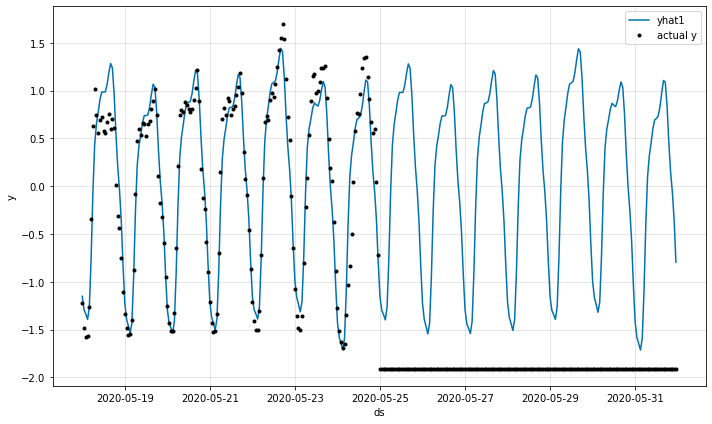

In [158]:
fig_forecast = m.plot(forecast)

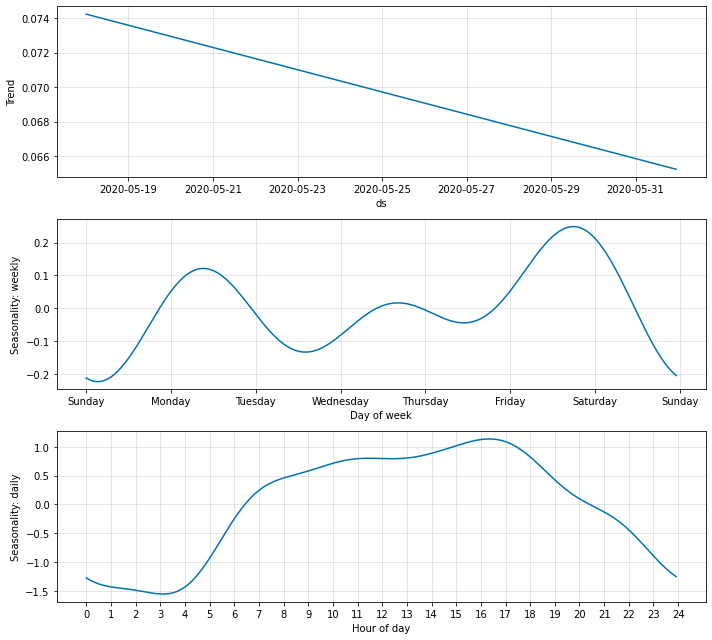

In [151]:
fig_components = m.plot_components(forecast)

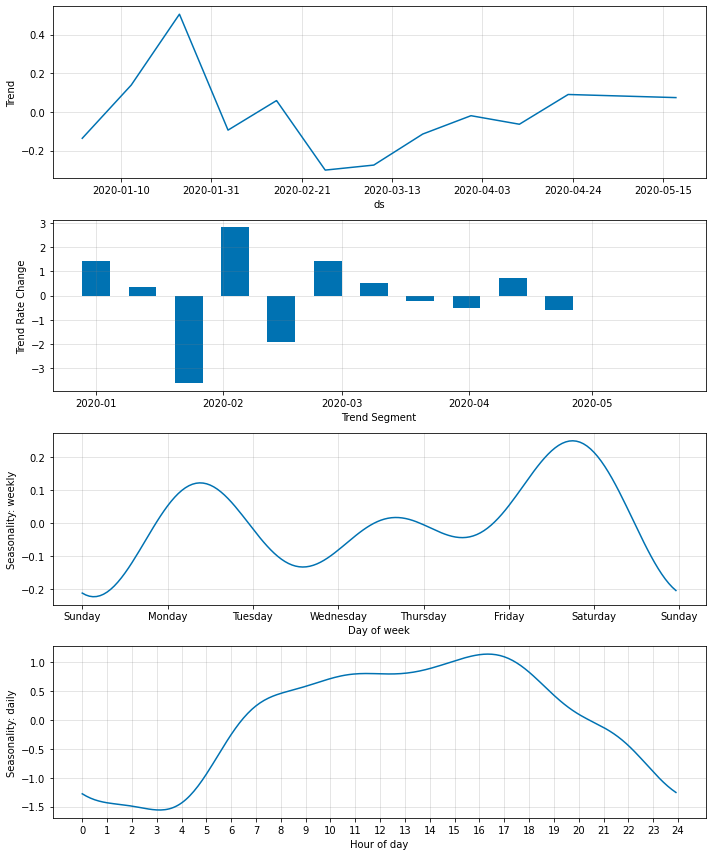

In [152]:
fig_model = m.plot_parameters()

In [216]:
result_df = m.predict_trend(clean_test_df)
result_df['trend']

0      0.074220
1      0.074193
2      0.074167
3      0.074140
4      0.074113
         ...   
331    0.065357
332    0.065331
333    0.065304
334    0.065277
335    0.065250
Name: trend, Length: 336, dtype: float64

## Inference

In [76]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [77]:
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20200525_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20200525_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20200525_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20200525_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,20200531_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,20200531_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,20200531_22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
pred = df_predict.iloc[168:,].reset_index(drop=True)

In [79]:
sub = pd.concat([submission_table['timestamp'], pred], axis=1)

In [80]:
sub

,timestamp,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,...,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1,yhat1
0,20200525_0,-1.156729,-1.087521,-0.879215,-0.635197,-0.996602,-0.754465,-0.966998,-0.980796,-0.594721,...,-1.027946,-1.177869,-1.500761,-1.493816,-0.460513,-0.818015,-1.230204,-1.205414,-1.103996,-1.142989
1,20200525_1,-1.298237,-1.162062,-0.910912,-0.697738,-1.037628,-0.804208,-1.087196,-1.064558,-0.654482,...,-1.064561,-1.244801,-1.562660,-1.642094,-0.530996,-0.900941,-1.296897,-1.236777,-1.136156,-1.172439
2,20200525_2,-1.343313,-1.141645,-0.886759,-0.702739,-1.001087,-0.776247,-1.155095,-1.068078,-0.664221,...,-0.977158,-1.246123,-1.605455,-1.732551,-0.565255,-0.879958,-1.220289,-1.140168,-1.076084,-1.110612
3,20200525_3,-1.395463,-1.152205,-0.929491,-0.716549,-1.072407,-0.811159,-1.200663,-1.099750,-0.714289,...,-1.034350,-1.318341,-1.667557,-1.827758,-0.602414,-0.888200,-1.222988,-1.169586,-1.120070,-1.136350
4,20200525_4,-1.263163,-1.062327,-0.915730,-0.674271,-1.095017,-0.820280,-1.044807,-1.040885,-0.712598,...,-1.110665,-1.187948,-1.424700,-1.589419,-0.581735,-0.866199,-1.272398,-1.170905,-1.081046,-1.086830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,0.459481,0.492850,0.383045,0.667015,0.551309,0.727690,0.550791,0.549278,0.882757,...,0.445393,0.561099,0.111111,0.259798,0.697338,0.729832,0.196293,0.493311,0.435565,0.449392
164,20200531_20,0.150117,0.025762,-0.093723,0.236853,-0.049915,0.142226,0.249496,0.090940,0.413113,...,-0.127978,0.171368,-0.296006,-0.067269,0.411639,0.259605,-0.466923,-0.117706,-0.150518,-0.134341
165,20200531_21,-0.060371,-0.297972,-0.354074,-0.046727,-0.344141,-0.185513,-0.010964,-0.198711,0.099705,...,-0.456524,-0.145962,-0.577037,-0.311560,0.166073,-0.040641,-0.815020,-0.501080,-0.445273,-0.478490
166,20200531_22,-0.356624,-0.545485,-0.508103,-0.242077,-0.498316,-0.346739,-0.325618,-0.430984,-0.133477,...,-0.593634,-0.464851,-0.900168,-0.647495,-0.077481,-0.271317,-0.935596,-0.688877,-0.596185,-0.671136


In [81]:
sub.columns = submission_table.columns

In [82]:
sub

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,-1.156729,-1.087521,-0.879215,-0.635197,-0.996602,-0.754465,-0.966998,-0.980796,-0.594721,...,-1.027946,-1.177869,-1.500761,-1.493816,-0.460513,-0.818015,-1.230204,-1.205414,-1.103996,-1.142989
1,20200525_1,-1.298237,-1.162062,-0.910912,-0.697738,-1.037628,-0.804208,-1.087196,-1.064558,-0.654482,...,-1.064561,-1.244801,-1.562660,-1.642094,-0.530996,-0.900941,-1.296897,-1.236777,-1.136156,-1.172439
2,20200525_2,-1.343313,-1.141645,-0.886759,-0.702739,-1.001087,-0.776247,-1.155095,-1.068078,-0.664221,...,-0.977158,-1.246123,-1.605455,-1.732551,-0.565255,-0.879958,-1.220289,-1.140168,-1.076084,-1.110612
3,20200525_3,-1.395463,-1.152205,-0.929491,-0.716549,-1.072407,-0.811159,-1.200663,-1.099750,-0.714289,...,-1.034350,-1.318341,-1.667557,-1.827758,-0.602414,-0.888200,-1.222988,-1.169586,-1.120070,-1.136350
4,20200525_4,-1.263163,-1.062327,-0.915730,-0.674271,-1.095017,-0.820280,-1.044807,-1.040885,-0.712598,...,-1.110665,-1.187948,-1.424700,-1.589419,-0.581735,-0.866199,-1.272398,-1.170905,-1.081046,-1.086830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,0.459481,0.492850,0.383045,0.667015,0.551309,0.727690,0.550791,0.549278,0.882757,...,0.445393,0.561099,0.111111,0.259798,0.697338,0.729832,0.196293,0.493311,0.435565,0.449392
164,20200531_20,0.150117,0.025762,-0.093723,0.236853,-0.049915,0.142226,0.249496,0.090940,0.413113,...,-0.127978,0.171368,-0.296006,-0.067269,0.411639,0.259605,-0.466923,-0.117706,-0.150518,-0.134341
165,20200531_21,-0.060371,-0.297972,-0.354074,-0.046727,-0.344141,-0.185513,-0.010964,-0.198711,0.099705,...,-0.456524,-0.145962,-0.577037,-0.311560,0.166073,-0.040641,-0.815020,-0.501080,-0.445273,-0.478490
166,20200531_22,-0.356624,-0.545485,-0.508103,-0.242077,-0.498316,-0.346739,-0.325618,-0.430984,-0.133477,...,-0.593634,-0.464851,-0.900168,-0.647495,-0.077481,-0.271317,-0.935596,-0.688877,-0.596185,-0.671136


In [83]:
final_sub = unscaling(sub)
final_sub

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,90599.346617,21397.774632,2245.558289,8868.803069,1862.076255,2015.767027,42787.667519,1591.964669,6200.085398,...,1164.036606,3649.580833,3749.641333,3278.399212,2989.484735,6800.681742,154.050979,2461.610857,2196.246762,3352.745750
1,20200525_1,73340.807941,18294.129932,2068.976417,8035.597935,1665.848592,1840.070472,35764.082499,1352.821829,5678.567721,...,1022.198560,3236.886339,2783.637121,2222.044633,2701.775702,6007.155240,28.949697,2210.850848,2028.767592,3079.563068
2,20200525_2,67843.257141,19144.230729,2203.531004,7968.967983,1840.627071,1938.829850,31796.447663,1342.770372,5593.580572,...,1360.780803,3228.733413,2115.775283,1577.615074,2561.932881,6207.944776,172.649681,2983.275056,2341.600489,3653.072208
3,20200525_3,61482.932066,18704.547895,1965.475342,7784.973485,1499.501313,1815.518997,29133.720217,1252.346746,5156.647443,...,1139.230522,2783.447794,1146.597226,899.346614,2410.253386,6129.075049,167.588000,2748.067096,2112.538217,3414.327077
4,20200525_4,77618.448085,22446.773305,2042.138353,8348.231509,1391.358220,1783.304120,38240.995657,1420.409219,5171.402691,...,843.601867,3587.431307,4936.663111,2597.306952,2494.664077,6339.604594,74.904416,2737.517970,2315.762641,3873.675783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,287715.833130,87199.606717,9277.569436,26217.737823,9265.717291,7250.827300,131477.951879,5960.379708,19093.682639,...,6871.445645,14371.810372,28904.806251,15771.384819,7715.764254,21612.060809,2829.864937,16043.504919,10213.781999,18123.706472
164,20200531_20,249985.138966,67751.482434,6621.510908,20486.840948,6390.069815,5182.930715,113872.140446,4651.806574,14995.211872,...,4650.326053,11968.783802,22551.270721,13441.316036,6549.557720,17112.446483,1585.808908,11158.213961,7161.652334,12708.981718
165,20200531_21,224313.540656,54272.210335,5171.105529,16708.796351,4982.788151,4025.338305,98652.456131,3824.844646,12260.178655,...,3377.606590,10012.170383,18165.442861,11700.953675,5547.170753,14239.385900,932.850439,8093.005629,5626.660034,9516.652847
166,20200531_22,188181.832908,43966.513864,4313.016003,14106.210922,4245.372344,3455.877299,80265.987852,3161.698006,10225.254827,...,2846.471375,8045.947213,13122.609536,9307.706490,4552.999143,12032.043059,706.674198,6591.497462,4840.760470,7729.663151


In [84]:
final_sub.to_csv('prediction.csv', index=False)